# Anwendung und Vergleich von Machine Learning und Deep Learning Algorithmen zur Vorhersage von COVID-19 Kennzahlen

## Regression
Mit einer Regression werden mit unabhängigen Variabeln $x^{n}$ abhängige Variabeln $y^{n}$ beschrieben. Die unabhängigen Variabeln sind numerisch. 
Die lineare Regression ist die einfachste Art der Regression. Sie geht davon aus dass die Beziehung linear ist. 
Bei der Polynomregression werden die Polynome von x verwendet: ${x}$, $x^{2}$, $x^{3}$...

## Imports

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import normalize
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

import plotly.graph_objs as go
from ipywidgets import interact

%matplotlib inline

# Konfiguration
Auf Windows funtktioniert eine relative Pfadangabe nicht. Darum untenstehende Konfiguration des absoluten Pfades wo das Projekt abgelegt ist.


In [39]:
#Path to raw_data -> change it localy
root_path =  "C:/Users/marco/IdeaProjects/ml-corona/"

## Laden der Daten

In [40]:
# Load the data from disk
X_train = np.load(root_path +'preprocessing/X_train.npy')
X_test = np.load(root_path +'preprocessing/X_test.npy')
y_train = np.load(root_path +'preprocessing/y_train.npy')
y_test = np.load(root_path +'preprocessing/y_test.npy')
full_dataset = np.load(root_path +'preprocessing/dataset.npy')

# Polynomiale Regression
## Normalisieren und Aufteilen

In [41]:
#Prepare the X and y data
X_all = pd.DataFrame(data=full_dataset)
y_all = X_all.copy()
#remove cases at position 0
X_all.pop(0)
#remove all other than cases
y_all = y_all.drop(y_all.columns[[1,2,3,4,5,6,7,8,9,10]], axis=1) 

# Split data in training and test set
num_datapoints = X_all.shape[0]
num_training = int(num_datapoints*0.7)

X_train, X_test = X_all[:num_training], X_all[num_training:]
y_train, y_test = y_all[:num_training], y_all[num_training:]

# Verify the shapes of train and test
# Scale the datasets using RobutScaler (as this scaler scales the data according to the quantile range (default: Inter Quartile Range IQR))
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_test = pd.DataFrame(scaler.fit_transform(X_test))
y_train = pd.DataFrame(scaler.fit_transform(y_train))
y_test = pd.DataFrame(scaler.fit_transform(y_test))

print(X_train.tail(5))


            0         1         2    3    4    5    6         7         8  \
457  0.918514  0.142857  0.990296  0.0  0.0  0.0  0.0  0.261364  0.160284   
458  0.959074  0.000000  0.965602  0.0  0.0  0.0  0.0  0.268939  0.152899   
459  0.884834  0.000000  1.000000  0.0  0.0  0.0  0.0  0.261364  0.145788   
460  0.480820  0.000000  0.486990  0.0  0.0  0.0  0.0  0.232955  0.126368   
461  0.234896  0.000000  0.202283  0.0  0.0  0.0  0.0  0.202652  0.117341   

            9  
457  0.018519  
458  0.027778  
459  0.018519  
460  0.037037  
461  0.000000  


## Polynom finden
Loop über alle Polynome um den Score und die Abweichung herauszufinden.

Polynom 2 mean squared error :      7057932559, score 3.60
Polynom 3 mean squared error :    463995430573, score 4.02
Polynom 4 mean squared error :          121249, score 4.27
Polynom 5 mean squared error :          322549, score 4.55
Polynom 6 mean squared error :       135704078, score 4.76
Polynom 7 mean squared error :     11959090641, score 4.89
Polynom 8 mean squared error :    110719043261, score 4.93
Polynom 9 mean squared error :    345682639807, score 4.93


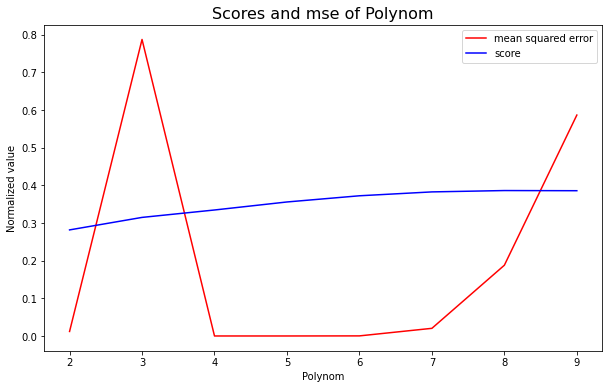

In [42]:
# Loop over polynoms
polynoms = [2,3,4,5,6,7,8,9]
scores = []
rmse = []
for i in polynoms:
    #Split the time series
    splits = TimeSeriesSplit(n_splits=5)
    rmse_list = []
    score_list = []
    poly = PolynomialFeatures(i)
    lr = LinearRegression()
    for split_train_index, split_test_index in splits.split(X_train):
        #Train
        #TODO:wir evaluieren Polynom nur mit X_train Daten (70%) und nicht mit allen Daten, also ohne Testdaten
        X_train_split = X_train.iloc[split_train_index]
        y_train_split = y_train.iloc[split_train_index]
        poly_features = poly.fit_transform(X_train_split)
        lr.fit(poly_features, y_train_split)
        score = lr.score(poly_features,y_train_split)
        score_list.append(score)

        #Test
        X_test_split = X_train.iloc[split_test_index]
        y_test_split = y_train.iloc[split_test_index]
        poly_features_test = poly.fit_transform(X_test_split)
        y_predicted = lr.predict(poly_features_test)
        poly_reg_rmse = np.sqrt(mean_squared_error(y_test_split, y_predicted))
        rmse_list.append(poly_reg_rmse)
    
    print(f"Polynom {i} mean squared error : {sum(rmse_list):15.0f}, score {sum(score_list):2.2f}")
    scores.append(sum(score_list))
    rmse.append(sum(rmse_list))

plt.figure(figsize=(10, 6))
plt.title("Scores and mse of Polynom", size=16)
plt.plot(polynoms, normalize([rmse])[0], c="red", label='mean squared error')
plt.plot(polynoms, normalize([scores])[0], c="blue", label='score')
plt.xlabel("Polynom")
plt.ylabel("Normalized value")
plt.legend()
plt.show()

## Training

In [43]:
poly = PolynomialFeatures(2)
lr = LinearRegression()
#Train
poly_features = poly.fit_transform(X_train)
lr.fit(poly_features, y_train)
score = lr.score(poly_features,y_train)
print(f"score {score}")

    

score 0.7717540212311249


## Evaluation
Evaluierung mit den Testdaten

mean squared error 0.2551249537160729


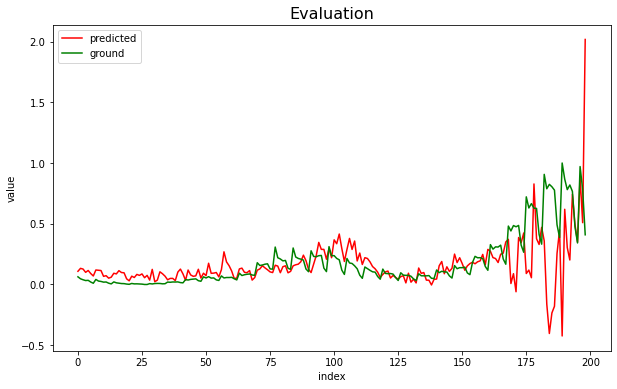

In [44]:

X_test_transformed = poly.fit_transform(X_test)
y_predicted = lr.predict(X_test_transformed)
poly_reg_rmse = np.sqrt(mean_squared_error(y_test, y_predicted))
print(f"mean squared error {poly_reg_rmse}")

plt.figure(figsize=(10, 6))
plt.title("Evaluation", size=16)
plt.plot(y_test.index, y_predicted, c="red", label='predicted')
plt.plot(y_test.index, y_test[0], c="green", label='ground')
plt.xlabel("index")
plt.ylabel("value")
plt.legend()
plt.show()